## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

**Цель:** предсказать медианную стоимость жилых массивов.

**Задачи:**  
1. Подготовка данных:
   * Инициализация Spark-сессии;    
   * Чтение датасета и вывод колонок;
   * Предобработка данных и исследовательский анализ;   
2. Обучение моделей:
   * Построение модели линейной регрессии на разных наборах данных;
   * Оенка метрик;
3. Анализ результатов
   * Общий вывывод.

# Описание данных

Датасет **`housing`**  
`longitude` — долгота;  
`latitude` — широта;   
`housing_median_age` — медианный возраст жителей жилого массива;   
`total_rooms` — общее количество комнат в домах жилого массива;    
`total_bedrooms` — общее количество спален в домах жилого массива;   
`population` — количество человек, которые проживают в жилом массиве;   
`households` — количество домовладений в жилом массиве;   
`median_income` — медианный доход жителей жилого массива;   
`median_house_value` — медианная стоимость дома в жилом массиве;   
`ocean_proximity` — близость к океану.


# Подготовка данных

Загрузка библиотек и инициализация Spark-сессии.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California_hous") \
                    .getOrCreate()

try: 
    data = spark.read.option('header', 'true').csv('/Users/user/Desktop/Курсы/Яндекс/spark/housing.csv', inferSchema = True)
except:
    data = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)

Выведем первые строки и тип столбцов на экран.

In [3]:
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Типы данных корректные.

In [4]:
data.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Данные в первых 10 строках выглядят корректными, посмотрим на описательные статистики.

In [5]:
data.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Итак, обнаружены пропуски в столбце `total_bedrooms`. Заполним пропуси медианным значением.  
Медианное и среднее значения у большинства признаком отличаются друг от друга не сильно, следовательное данные более менее сбалансированные. Целевой признак `median_house_value` имеет сильный разброс между средним значением и медианой, что свидетельствует о начилии выбросов.  

In [6]:
data = data.fillna(435, subset=['total_bedrooms'])

columns = data.columns

for column in columns:
    check_col = F.isnan(F.col(column)) | F.isnull(F.col(column))
    print(column, data.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Проведем иследовательский анализ данных.    
Не будем исследовать географические данные.

In [7]:
def spark_research(data, research_col, new_col, number):
    '''
    Performs analysis on a Spark DataFrame and visualizes the result.

    Parameters:
    data (DataFrame): The input Spark DataFrame.
    research_col: The name of the column to be analyzed.
    new_col (str): The name of the new column to be created in the DataFrame.
    number (int): A numeric value used in computation for binning.

    Returns:
    A graphical visualization.
    '''
    df_binned = data.withColumn(new_col, (F.col(research_col) / number).cast('int') * number).groupBy(new_col).agg(F.count('*').alias('count')).toPandas()
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 7))
    sns.barplot(x=new_col, y='count', data=df_binned)
    plt.title(f'Количество жилых массивов по {research_col}')
    plt.xticks(rotation=90)
    plt.show()

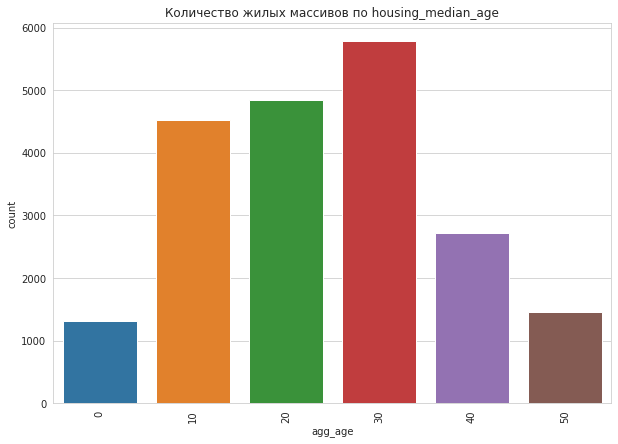

In [8]:
spark_research(data, 'housing_median_age', 'agg_age', 10)

Больше всего жильцов от 10 до 40 лет.

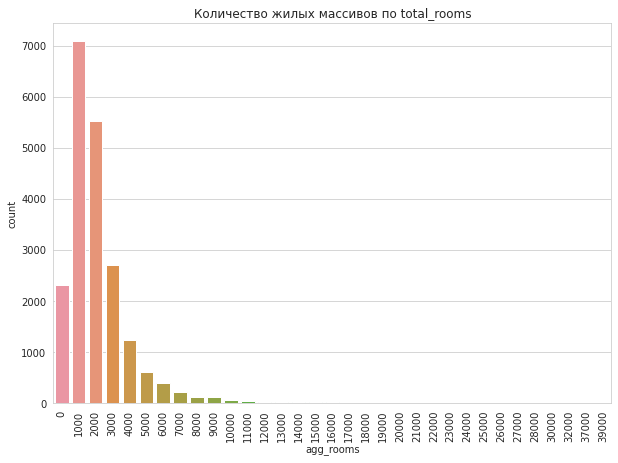

In [9]:
spark_research(data, 'total_rooms', 'agg_rooms', 1000)

В большинстве жилых массивов от 1000 до 2000 комнат, у гистограммы длинный правых хвост свидетельствующий о наличии незначительных "выбросов".

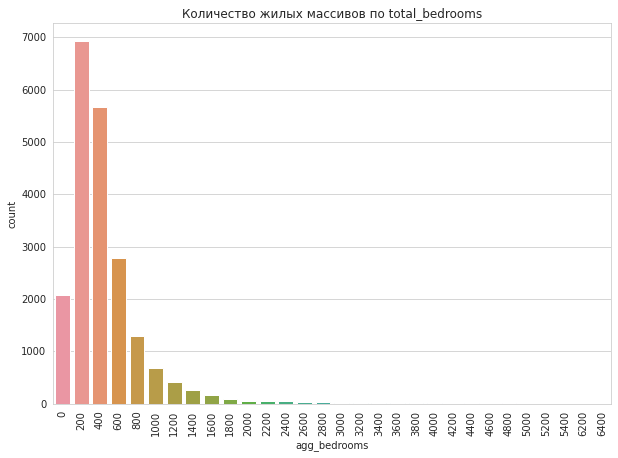

In [10]:
spark_research(data, 'total_bedrooms', 'agg_bedrooms', 200)

Больше всего массивов с количеством спален от 200 до 600, у гистограммы длинный правых хвост свидетельствующий о наличии "выбросов".

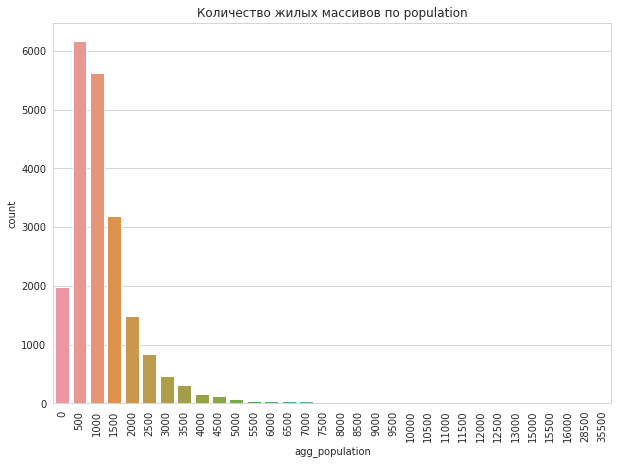

In [11]:
spark_research(data, 'population', 'agg_population', 500)

Население в стандартном жилом массиве от 500 до 1500 человек, у гистограммы длинный правых хвост свидетельствующий о наличии "выбросов".

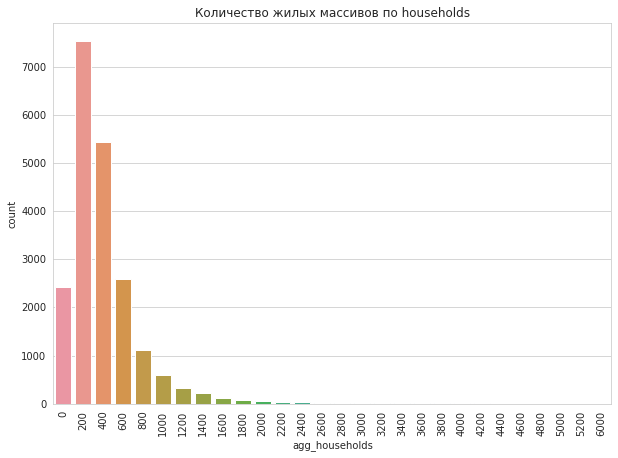

In [12]:
spark_research(data, 'households', 'agg_households', 200)

Количество домовладений в жилых массивов основной массе от 200 до 600.

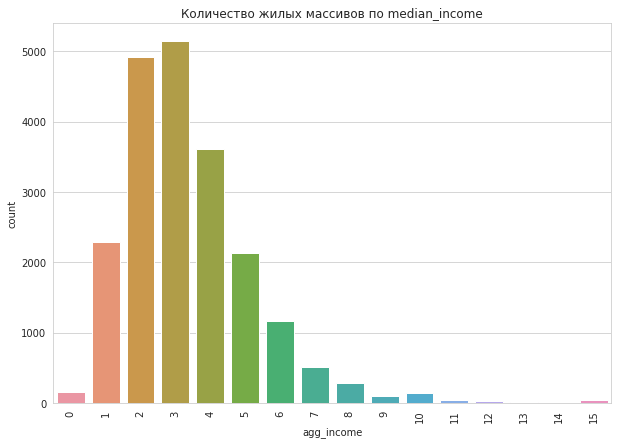

In [13]:
spark_research(data, 'median_income', 'agg_income', 1)

Медианный доход жителей массива в основном от 2 до 4 тыс.долларов.

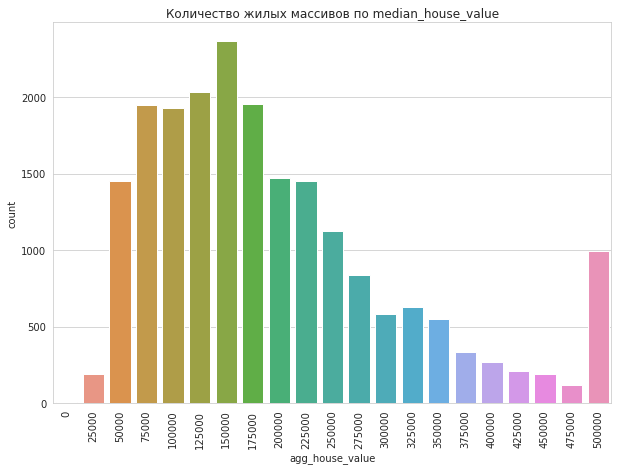

In [14]:
spark_research(data, 'median_house_value', 'agg_house_value', 25000)

Медианная стоимость дома в большинстве жилых массивов составляет от 75000 до 175000 долларов. Так же имеется масса жилых массивов (почти 1000) у которых стоимость составляет 500000.

In [15]:
rich = data.filter(F.col('median_house_value') > 500000)
rich.show(10)
data.filter(F.col('median_house_value') > 500000).count()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.27|    37.8|              52.0|      249.0|          78.0|     396.0|      85.0|       1.2434|          500001.0|       NEAR BAY|
|  -122.25|   37.87|              52.0|      609.0|         236.0|    1349.0|     250.0|       1.1696|          500001.0|       NEAR BAY|
|  -122.24|   37.86|              52.0|     1668.0|         225.0|     517.0|     214.0|       7.8521|          500001.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     3726.0|         474.0|    1366.0|     496.0|       9.3959|          500001.0|       NEAR BAY|
|  -122.23|   37.83|              

965

Text(0.5, 1.0, 'Количество жилых массивов дороже 500 тыс. по удаленности от океана')

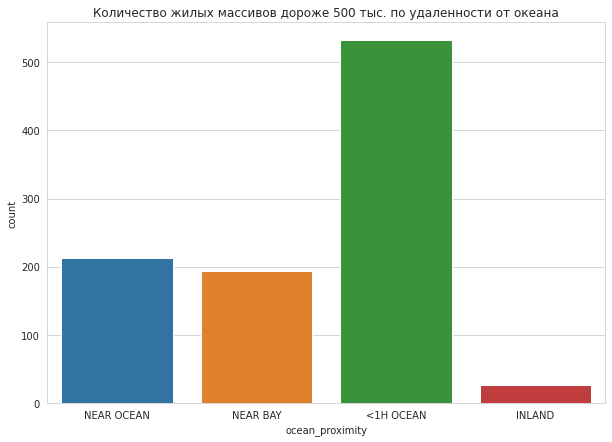

In [16]:
rich_ocean = rich.groupBy('ocean_proximity').count().toPandas()
plt.figure(figsize=(10,7))
sns.barplot(x='ocean_proximity', y='count', data=rich_ocean)
plt.title('Количество жилых массивов дороже 500 тыс. по удаленности от океана')

Скорее всего жилые массивы с медианной стоимостью в 500001 доллар не являются ошибкой, такие массивы располагаются в "дорогих" районах Калифорнии или в районе где более часа до океана, но возможно это связанно с тем, что жилье маленькой площади и в массив попадает большое количество квартир, за счет чего стоимость выше.

Text(0.5, 1.0, 'Количество жилых массивов по удаленности от океана')

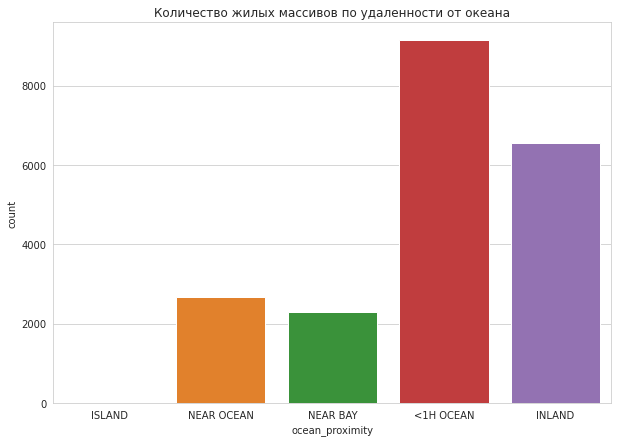

In [17]:
cat = data.groupBy('ocean_proximity').count().toPandas()

plt.figure(figsize=(10,7))
sns.barplot(x='ocean_proximity', y='count', data=cat)
plt.title('Количество жилых массивов по удаленности от океана')

Больше всего жилых массивов (более 8000) располагается в более чем часе езды от океана, менее всего распространено жилье на островах Калифорнии.

Добавим навые признаки из практикума.

In [18]:
data = data.withColumn('rooms_per_household', F.col('total_rooms')/F.col('households'))
data = data.withColumn('population_in_household', F.col('population')/F.col('households'))
data = data.withColumn('bedroom_index', F.col('total_bedrooms')/F.col('total_rooms'))
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



25/04/20 04:13:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/04/20 04:13:31 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_in_household,bedroom_index
longitude,1.00,-0.92,-0.11,0.04,0.07,0.10,0.06,-0.02,-0.05,-0.03,0.00,0.08
latitude,-0.92,1.00,0.01,-0.04,-0.07,-0.11,-0.07,-0.08,-0.14,0.11,0.00,-0.10
housing_median_age,-0.11,0.01,1.00,-0.36,-0.32,-0.30,-0.30,-0.12,0.11,-0.15,0.01,0.14
total_rooms,0.04,-0.04,-0.36,1.00,0.93,0.86,0.92,0.20,0.13,0.13,-0.02,-0.19
total_bedrooms,0.07,-0.07,-0.32,0.93,1.00,0.87,0.97,-0.01,0.05,0.00,-0.03,0.07
population,0.10,-0.11,-0.30,0.86,0.87,1.00,0.91,0.00,-0.02,-0.07,0.07,0.01
households,0.06,-0.07,-0.30,0.92,0.97,0.91,1.00,0.01,0.07,-0.08,-0.03,0.03
median_income,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00,0.69,0.33,0.02,-0.55
median_house_value,-0.05,-0.14,0.11,0.13,0.05,-0.02,0.07,0.69,1.00,0.15,-0.02,-0.23
rooms_per_household,-0.03,0.11,-0.15,0.13,0.00,-0.07,-0.08,0.33,0.15,1.00,-0.00,-0.37


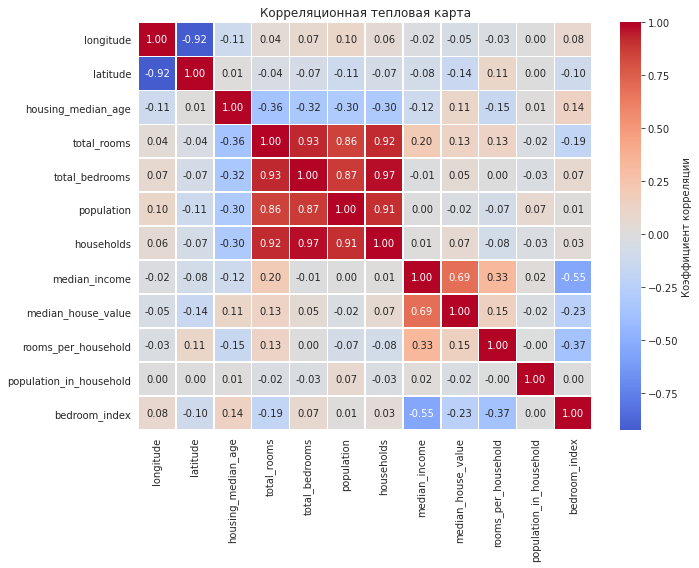

In [19]:
num_col = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rooms_per_household', 'population_in_household', 'bedroom_index']

assembler = VectorAssembler(inputCols=num_col, outputCol='features')
df_vector = assembler.transform(data).select('features')

corr_matrix = Correlation.corr(df_vector, 'features', 'pearson').head()[0]
corr_array = corr_matrix.toArray()
corr_df = pd.DataFrame(corr_array, index=num_col, columns=num_col)

display(corr_df.round(2))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, 
            annot=True,       
            fmt=".2f",        
            cmap="coolwarm",  
            center=0,
            linewidths=0.5,     
            cbar_kws={'label': 'Коэффициент корреляции'}) 
plt.title("Корреляционная тепловая карта")
plt.tight_layout()
plt.show()

Наблюдается мультиколлинеарность между признаками `total_rooms`, `total_bedrooms`, `population`, `households` так же между `longitude` и `latitude`. Целевой признак имеет умеренную положительную зависимость с `median_income` и умеренную отрицательную с `bedroom_index`.

### Промежуточный вывод

1. Инициализирована Spark-сессия "California_House".
2. Загружены данные, установлен тип данных, выявлены пропуске в столбце "total_bedrooms" и заполнены медианным значением.
3. Проведен исследовательский анализ данных, установлено, что чаще в жилых массивах жильцы от 10 до 40 лет, от 1000 до 2000 комнат,  количеством спален от 200 до 600, население от от 500 до 1500 человек, количество домовладений от 200 до 600, медианный доход жителей от 2 до 4 тыс.долларов, медианная стоимость дома от 75000 до 175000 долларов, и в расположении более часа до океана.
4. Добавлены новые признаки `rooms_per_household`, `population_in_household`, `bedroom_index`.
5. Выявлено наличие мультиколлиеарность по нескольким признакам, которые будут удалены.

# Обучение моделей

Удалим ненужные столбцы.

In [20]:
df_list = ['housing_median_age', 'total_rooms', 'median_income','ocean_proximity', 'median_house_value', 'rooms_per_household', 'population_in_household', 'bedroom_index']
df = data.select(df_list)
df.show(5)

+------------------+-----------+-------------+---------------+------------------+-------------------+-----------------------+-------------------+
|housing_median_age|total_rooms|median_income|ocean_proximity|median_house_value|rooms_per_household|population_in_household|      bedroom_index|
+------------------+-----------+-------------+---------------+------------------+-------------------+-----------------------+-------------------+
|              41.0|      880.0|       8.3252|       NEAR BAY|          452600.0|  6.984126984126984|     2.5555555555555554|0.14659090909090908|
|              21.0|     7099.0|       8.3014|       NEAR BAY|          358500.0|  6.238137082601054|      2.109841827768014|0.15579659106916466|
|              52.0|     1467.0|       7.2574|       NEAR BAY|          352100.0|  8.288135593220339|     2.8022598870056497|0.12951601908657123|
|              52.0|     1274.0|       5.6431|       NEAR BAY|          341300.0| 5.8173515981735155|      2.547945205479452

In [21]:
train_data, test_data = df.randomSplit([.8, .2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16418 4222


In [22]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ['housing_median_age', 'total_rooms', 'median_income','ocean_proximity', 'rooms_per_household', 'population_in_household', 'bedroom_index']
target = 'median_house_value' 

Закодируем категориальный признак.

In [23]:
indexer = StringIndexer(inputCol='ocean_proximity',outputCol='encoded_ocean').fit(train_data)

idx_train_data = indexer.transform(train_data)
idx_test_data = indexer.transform(test_data)

encoder = OneHotEncoder(inputCols=['encoded_ocean'],outputCols=['ocean_ohe']).fit(idx_train_data)
enc_train_data = encoder.transform(idx_train_data)
enc_test_data = encoder.transform(idx_test_data)

enc_test_data.select('ocean_proximity', 'encoded_ocean', 'ocean_ohe').show(3)

+---------------+-------------+-------------+
|ocean_proximity|encoded_ocean|    ocean_ohe|
+---------------+-------------+-------------+
|         INLAND|          1.0|(4,[1],[1.0])|
|      <1H OCEAN|          0.0|(4,[0],[1.0])|
|      <1H OCEAN|          0.0|(4,[0],[1.0])|
+---------------+-------------+-------------+
only showing top 3 rows



In [24]:
feature_cols_all = ['housing_median_age', 'total_rooms', 'median_income',
                    'rooms_per_household', 'population_in_household', 'bedroom_index', 'ocean_ohe']

assembler_all = VectorAssembler(inputCols=feature_cols_all, outputCol='features')
train_assembled_all = assembler_all.transform(enc_train_data)
test_assembled_all = assembler_all.transform(enc_test_data)

lr_all = LinearRegression(featuresCol='features', labelCol='median_house_value', regParam=0.01)
model_all = lr_all.fit(train_assembled_all)
predictions_all = model_all.transform(test_assembled_all)


feature_cols_num = ['housing_median_age', 'total_rooms', 'median_income',
                    'rooms_per_household', 'population_in_household', 'bedroom_index']

assembler_num = VectorAssembler(inputCols=feature_cols_num, outputCol='features')
train_assembled_num = assembler_num.transform(train_data)
test_assembled_num = assembler_num.transform(test_data)

lr_num = LinearRegression(featuresCol='features', labelCol='median_house_value', regParam=0.01)
model_num = lr_num.fit(train_assembled_num)
predictions_num = model_num.transform(test_assembled_num)

25/04/20 04:13:39 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/20 04:13:39 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [25]:
evaluator_rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

rmse_all = evaluator_rmse.evaluate(predictions_all)
mae_all = evaluator_mae.evaluate(predictions_all)
r2_all = evaluator_r2.evaluate(predictions_all)

rmse_num = evaluator_rmse.evaluate(predictions_num)
mae_num = evaluator_mae.evaluate(predictions_num)
r2_num = evaluator_r2.evaluate(predictions_num)

In [26]:
print("Модель на всех признаках:")
print(f"RMSE: {rmse_all:.2f}, MAE: {mae_all:.2f}, R2: {r2_all:.4f}")

print("\nМодель только на числовых признаках:")
print(f"RMSE: {rmse_num:.2f}, MAE: {mae_num:.2f}, R2: {r2_num:.4f}")

Модель на всех признаках:
RMSE: 71910.06, MAE: 52676.28, R2: 0.6221

Модель только на числовых признаках:
RMSE: 77405.82, MAE: 57485.24, R2: 0.5621


**Промежуточный вывод**
1. Удалены признаки вызывающие мультиколлинеарность.
2. Категориальный признак закодирован OneHotEncoder.
3. Обучены две модели линейной регрессии: одна на числовых признаках, другая на всех.
4. Оценены метрики: Корень из средней квадратичной ошибки, Средняя абсолютная ошибка, Коэффициент детерминации.

# Анализ результатов

**Выводы:**
Модель на всех признаках (включая категориальные) показала лучшие результаты по всем метрикам:  
- Ошибки RMSE и MAE ниже — значит, предсказания ближе к фактическим значениям.  
- R² выше, что говорит о лучшем объяснении дисперсии целевой переменной.

Категориальный признак ocean_proximity оказался значимым:
- Его кодирование (сначала через StringIndexer, затем OneHotEncoder) добавило полезную информацию в модель.
- Особенно это логично в контексте недвижимости — расстояние до океана может сильно влиять на стоимость жилья.
- Разница в R² почти 6% (0.6221 против 0.5621) — это существенное улучшение, особенно для простой линейной модели.

In [27]:
spark.stop()